In [1]:
import sys
import numpy as np
import pandas as pd

# Alternate between ../../ and ../../src due to bug
sys.path.append('../..')

from cryptolib.exchange import Binance
from cryptolib.config import config
from utils.strategy import StrategyParamsEnum, Strategy

exchange = Binance(config.BINANCE_API_KEY, config.BINANCE_API_SECRET, streaming=False)

# Checking if the values are the same
print(exchange.get_last_price('ETHUSDT'))
print('Sandbox:', exchange.sandbox)
print('Streaming:', exchange.streaming)

1720.52
Sandbox: False
Streaming: False


### Charting config

In [2]:
import matplotlib.pyplot as plt
from bokeh.layouts import row
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.models.tools import HoverTool
from bokeh.palettes import Category10, Dark2_5
from bokeh.io import output_notebook
import itertools

output_notebook()

def plot_signals_matplot(data, signals):
    plt.figure(figsize=(16, 9))
    plt.plot(data.index, data['close'], label='Closing Price')
    # Plot buy signals as vertical lines
    plt.plot(signals[signals == 1].index, data["close"][signals == 1], "^", markersize=10, color="g", label="Buy")
    # Plot sell signals as vertical lines
    plt.plot(signals[signals == -1].index, data["close"][signals == -1], "v", markersize=10, color="r", label="Sell")
    plt.title("Asset price with buy and sell signals")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()


colors = itertools.cycle(Dark2_5)
def plot_signals(data, signals, width=1200, height=800, display=True):
    # Plot the history of orders for each bot in bokeh
    p = figure(width=width, height=height, x_axis_type="datetime")
    p.title.text = 'Asset price with buy and sell signals'
    p.xaxis.axis_label = 'Date'
    p.yaxis.axis_label = 'Price'
    source = ColumnDataSource(data=dict(x=data.index, y=data['close']))
    p.line(x="x", y="y", source=source, line_width=2, color=next(colors), legend_label="Closing Price", name="price")

    # Plot buy signals as vertical lines
    buy_source = ColumnDataSource(data=dict(x=signals[signals == 1].index, y=data["close"][signals == 1]))
    p.triangle(x="x", y="y", source=buy_source, size=10, color="green", legend_label="Buy")

    # Plot sell signals as vertical lines
    sell_source = ColumnDataSource(data=dict(x=signals[signals == -1].index, y=data["close"][signals == -1]))
    p.inverted_triangle(x="x", y="y", source=sell_source, size=10, color="red", legend_label="Sell")

    p.legend.location = "top_left"
    p.legend.click_policy = "hide"
    p.add_tools(HoverTool(
        tooltips=[
            ('date', '@x{%F}'),
            ('price', '@y{0.00000}')
        ],
        formatters={
            '@x': 'datetime',
        },
        mode='vline',
        names=['price']
    ))

    if display:
        show(p)
    return p

Loading BokehJS ...

In [55]:
from pytvlwcharts import Chart, TimeScaleOptions

def plot_tv(df):
    chart = Chart(width=1360,
                  height=400,
                  time_scale=TimeScaleOptions(
                        time_visible=True,
                        seconds_visible=False,
                  ))
    chart.mark_candlestick(data=df, scaleMargins={'top': 0.1, 'bottom': 0.4})
    return chart


### Data generator

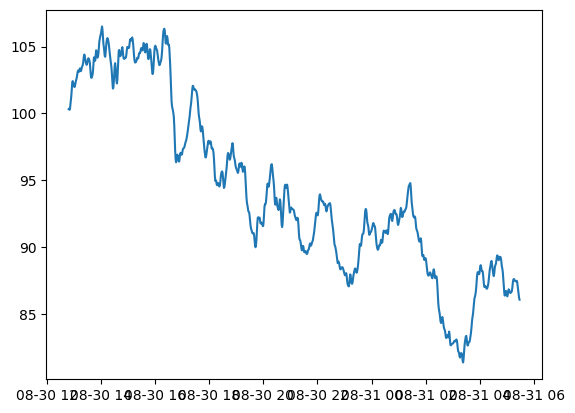

In [3]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

from cryptolib.enums import Interval

class StockMarketSimulation:
    def __init__(self, start_price, points, time_interval: Interval, start_date: datetime = datetime.today(), drift = 0.0, volatility = 0.05, smoothing = 0, price_diff = 0.01):
        self.start_price = start_price
        self.drift = drift
        self.volatility = volatility
        self.smoothing = smoothing
        self.price_diff = price_diff
        self.points = points
        self.time_interval = self.convert_interval(time_interval)
        self.start_date = start_date

    def convert_interval(self, interval):
        unit = interval.value[-1]
        value = int(interval.value[:-1])

        if unit == "m":
            return value
        elif unit == "h":
            return value * 60
        else:  # assuming the unit is 'd' for days
            return value * 60 * 24
        
    def smooth(self, data, smoothing = None):

        if smoothing is None:
            smoothing = self.smoothing

        for i in range(smoothing):
            data = [data[0]] + [(data[i] + data[i+1])/2   for i in range(0, len(data) - 1)]
        return data

    def simulate(self):
        times = [self.start_date + timedelta(minutes=i*self.time_interval) for i in range(self.points)]
        standard_normal_values = np.random.standard_normal(size = self.points)

        # Applying geometric Brownian motion
        prices = self.start_price * np.exp(np.cumsum((self.drift - 0.5 * self.volatility**2) * self.time_interval
                        + self.volatility * np.sqrt(self.time_interval) * standard_normal_values))

        ohlc_data = []
        for price in prices:
            open_price = price
            close_price = price + np.random.normal(0, price*self.price_diff)
            high_price = max(open_price, close_price) + abs(np.random.normal(0, price*self.price_diff))
            low_price = min(open_price, close_price) - abs(np.random.normal(0, price*self.price_diff))
            volume = np.random.randint(100, 1000)
            ohlc_data.append([open_price, high_price, low_price, close_price, volume])

        # Smooth the data
        ohlc_data = np.array(ohlc_data)
        ohlc_data[:, 0] = self.smooth(ohlc_data[:, 0])
        ohlc_data[:, 1] = self.smooth(ohlc_data[:, 1])
        ohlc_data[:, 2] = self.smooth(ohlc_data[:, 2])
        ohlc_data[:, 3] = self.smooth(ohlc_data[:, 3])

        return pd.DataFrame(ohlc_data, columns=['open', 'high', 'low', 'close', 'volume'], index=times)

# Create an instance of the class and simulate
simulator = StockMarketSimulation(start_price=100, points=1000, 
                                  time_interval=Interval.MINUTE_1, price_diff=0.001, smoothing=4, volatility=0.005)
stock_data = simulator.simulate()
plt.plot(stock_data.index, stock_data['close'])


### Strategy Analysis

In [4]:
class StrategyAnalyser:
    CAPITAL = 5000

    def remove_repeated_signals(self, signals):
        """Removes repeated signals."""
        prior_signal = 0
        i = 1
        while i < len(signals):
            if signals[i] == 1 or signals[i] == -1:
                if signals[i] == prior_signal:
                    signals[i] = 0
                else:
                    prior_signal = signals[i]

            i += 1

        # fill in the NaN values with zeros
        signals = signals.fillna(0)

        return signals

    def find_best_fit(self, symbol, interval, strategy_params_enum: StrategyParamsEnum, data = None, fee=0.001, p=1.0):
        """Finds the best fit for the strategy parameters"""

        if data is None:
            data = self.fetch_data(symbol, interval)

        def _find_best_fit(
            params, func, vals, best_fit
        ):
            # If there are no parameters for the strategy, just run it
            if len(params) < 1:
                return

            if len(params) == 1:
                param_range = params[0][1]
                for val in range(param_range[0], param_range[1]):
                    vals[params[0][0]] = val
                    signals = func(**vals)
                    score, history = self.calculate_total_gain(data, signals, symbol, fee)
                    if score > best_fit["score"]:
                        best_fit["params"] = vals.copy()
                        best_fit["score"] = score
                        best_fit["history"].append((vals.copy(), score))
                return
                        
            param_range = params[0][1]
            for val in range(param_range[0], param_range[1]):
                vals[params[0][0]] = val
                _find_best_fit(
                    params[1:], func, vals, best_fit
                )

            return best_fit

        params = list(strategy_params_enum.value.items())
        if strategy_params_enum == StrategyParamsEnum.MACD:
            strat = Strategy(data, p).macd
        elif strategy_params_enum == StrategyParamsEnum.BOLLINGER_BANDS:
            strat = Strategy(data, p).bollinger_bands
        elif strategy_params_enum == StrategyParamsEnum.STOCHASTIC_OSCILLATOR:
            strat = Strategy(data, p).stochastic_oscillator
        elif strategy_params_enum == StrategyParamsEnum.WILLIAMS_R:
            strat = Strategy(data, p).williams_r
        elif strategy_params_enum == StrategyParamsEnum.AVERAGE_DIRECTIONAL_INDEX:
            strat = Strategy(data, p).average_directional_index
        elif strategy_params_enum == StrategyParamsEnum.COMMODITY_CHANNEL_INDEX:
            strat = Strategy(data, p).commodity_channel_index
        elif strategy_params_enum == StrategyParamsEnum.RSI:
            strat = Strategy(data, p).rsi
        elif strategy_params_enum == StrategyParamsEnum.CHAIKIN_OSCILLATOR:
            strat = Strategy(data, p).chaikin_oscillator
        elif strategy_params_enum == StrategyParamsEnum.KNOW_SURE_THING:
            strat = Strategy(data, p).know_sure_thing
        elif strategy_params_enum == StrategyParamsEnum.TRIX:
            strat = Strategy(data, p).trix

        best_fit = {"params": {}, "score": -99999, "history": []}
        _find_best_fit(params, strat, {}, best_fit)
        return best_fit["params"], best_fit["score"], best_fit["history"]

    def fetch_data(self, symbol, interval, limit=1000):
        return exchange.get_historical_klines(symbol, interval, limit)

    def calculate_total_gain(self, data, signals, symbol, fee=0.001):

        # Always set the last signal to -1 to simulate closed position if not a buy
        if signals[-1] == 0:
            signals[-1] = -1

        investment = self.CAPITAL
        history = [self.CAPITAL]
        units = 0.0
        position = 0  # 0 for not holding, 1 for holding
        buy_price = 0.0
        for i in range(1, len(signals)):
            if signals[i] == 1 and position == 0:  # Buy
                position = 1
                buy_price = data["close"][i]
                units = (investment / buy_price) * (1 - fee)
            elif signals[i] == -1 and position == 1:  # Sell
                position = 0
                sell_price = data["close"][i]
                investment = (sell_price * units) * (1 - fee)
                history.append(investment)

        return investment - self.CAPITAL, history

#### Fitter
Given historical closing price data, find the best parameters for a specific strategy by maximizing the profit.

In [18]:
from cryptolib.enums import Interval

fee = 0.002
symbols = [
    "BTCUSDT",
]

analyser = StrategyAnalyser()

def best_fit_intervals(strategy):
    fit_history = []
    for symbol in symbols:
        print(f"\n### {symbol}")

        # iterate intervals
        for interval in Interval:
            # find best fit
            best_fit, score, history = analyser.find_best_fit(symbol, interval.value, strategy, fee=fee, p=0.2)
            fit_history.append({"best_fit": best_fit, "score": score, "history": history})

            print(" * * * ")
            print(f"Best fit for {interval.value} is {best_fit} with a P&L score of ${score}")
        print(" * * * ")

    return fit_history

def best_fit_iteration(strategy, n=100):
    fit_history = []
    for i in range(n):
        print(f"\n### Iteration {i}")

        data = simulator.simulate()
        # find best fit
        best_fit, score, history = analyser.find_best_fit("", "", strategy, data)
        
        fit_history.append({"best_fit": best_fit, "score": score, "history": history, "data": data.to_dict(orient="list")})
        print(" * * * ")
        print(f"Best fit is {best_fit} with a P&L score of ${score}")

    return fit_history

history = best_fit_intervals(StrategyParamsEnum.BOLLINGER_BANDS)
# history = best_fit_iteration(StrategyParamsEnum.CHAIKIN_OSCILLATOR, 12)


### BTCUSDT
 * * * 
Best fit for 1m is {'window': 1, 'std': 1} with a P&L score of $0
 * * * 
Best fit for 3m is {'window': 22, 'std': 3} with a P&L score of $287.2833492779755
 * * * 
Best fit for 5m is {'window': 19, 'std': 2} with a P&L score of $295.34786343028736
 * * * 
Best fit for 15m is {'window': 8, 'std': 2} with a P&L score of $232.26579054072408
 * * * 
Best fit for 30m is {'window': 9, 'std': 2} with a P&L score of $257.4219146991363
 * * * 
Best fit for 1h is {'window': 9, 'std': 2} with a P&L score of $111.68420836704718
 * * * 
Best fit for 2h is {'window': 7, 'std': 2} with a P&L score of $531.6966174098015
 * * * 
Best fit for 4h is {'window': 10, 'std': 2} with a P&L score of $531.6489144014122
 * * * 
Best fit for 6h is {'window': 23, 'std': 1} with a P&L score of $3106.632214586448
 * * * 
Best fit for 8h is {'window': 12, 'std': 1} with a P&L score of $2980.9297417102534
 * * * 
Best fit for 12h is {'window': 10, 'std': 1} with a P&L score of $1687.4065819860143

**Load and Store the history of the fitted strategy**

In [255]:
import json

def load_history(filename):
    with open(f'data/strategy_histories/{filename}') as f:
        return json.load(f)

def dump_history(filename, history):
    with open(f'data/strategy_histories/{filename}', 'w') as f:
        json.dump(history, f, indent=4)

dump_history("chaikin.json", history)
# history = load_history("chaikin.json")

**Visualise the profitable parameter fits found for the strategy and the signals generated**

In [274]:
positives = []
for item in history:
    if item["score"] > 0:
        positives.append(item)

# Sort by score
positives = sorted(positives, key=lambda x: x["score"], reverse=False)

# Plot the best fit
plots = []
for i, item in enumerate(positives):

    if i > 0 and i % 3 == 0:
        show(row(*plots))
        plots = []

    print(f"Graph {i%3 + 1} is {positives[i]['best_fit']} with a P&L score of ${positives[i]['score']}")
    df = pd.DataFrame.from_dict(positives[i]['data'])
    signals = Strategy(df).macd(**positives[i]['best_fit'])
    signals.iloc[-1] = -1
    signals = analyser.remove_repeated_signals(signals)
    p = plot_signals(df, signals, width=400, height=300, display=False)
    plots.append(p)

show(row(*plots))

    

Graph 1 is {'short_window': 19, 'long_window': 20, 'signal_window': 1} with a P&L score of $68.36884724503943


KeyError: 'data'

#### Average Best Fit
Given N historical closing price data, find the parameters that perform the best over a varied range of graph trends.

Best gain: 2266.9462644228843 with 7 orders
Average gain: -132.8499933568998
Median gain: -178.3962830158598 with 13 orders
Worst gain: -880.7467922211481 with 18 orders


Figure(id='14686', ...)

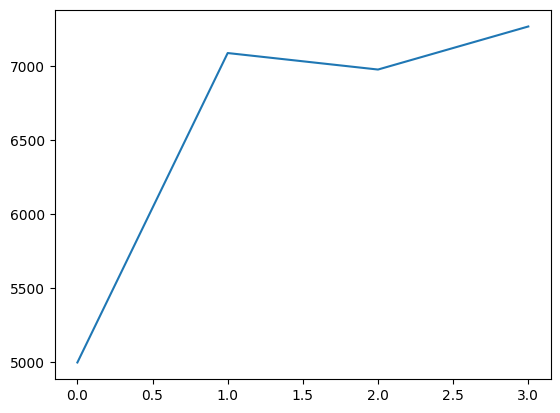

In [17]:
iterations = 100
simulator = StockMarketSimulation(start_price=100, points=1000, 
                                  time_interval=Interval.MINUTE_1, price_diff=0.001, smoothing=2, volatility=0.005)
analyser = StrategyAnalyser()

def calc_performance(data):
    signals = Strategy(data, 0.01).macd(4, 30)
    signals.iloc[-1] = -1
    signals = analyser.remove_repeated_signals(signals)
    gain, history = analyser.calculate_total_gain(data, signals, "BTCUSDT", fee=0.002)
    orders = len([signal for signal in signals if signal != 0])
    return gain, orders, history, signals

performance = []
for i in range(iterations):
    data = simulator.simulate()
    gain, orders, history, signals = calc_performance(data)
    performance.append({"gain": gain, "orders": orders, "data": data, "signals": signals, "history": history})

performance = sorted(performance, key=lambda x: x["gain"], reverse=True)

print(f"Best gain: {performance[0]['gain']} with {performance[0]['orders']} orders")
print(f"Average gain: {np.average([item['gain'] for item in performance])}")
print(f"Median gain: {performance[int(iterations/2)]['gain']} with {performance[int(iterations/2)]['orders']} orders")
print(f"Worst gain: {performance[-1]['gain']} with {performance[-1]['orders']} orders")

plot_signals(performance[0]['data'], performance[0]['signals'], width=800, height=400)
plt.plot(performance[0]['history'])
plot_signals(performance[-1]['data'], performance[-1]['signals'], width=800, height=400)

#### Plot a single strategy

Total gain: 373.63796938868654
Number of orders: 16


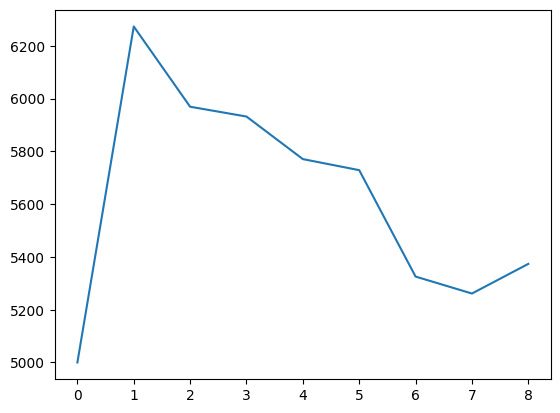

In [46]:
analyser = StrategyAnalyser()
data = analyser.fetch_data("BTCUSDT", Interval.HOUR_6.value, 1000)
# data = simulator.simulate()

# signals = Strategy(data, 0.1).macd(3, 39)
signals = Strategy(data, 0.2).bollinger_bands(23, 2)
signals.iloc[-1] = -1
signals = analyser.remove_repeated_signals(signals)
gain, history = analyser.calculate_total_gain(data, signals, "BTCUSDT", fee=0.002)

print(f"Total gain: {gain}")
print("Number of orders:", len([signal for signal in signals if signal != 0]))
plot_signals(data, signals, width=800, height=400)
plt.plot(history)